# Project: Bitcoin Price Prediction Using LSTM

This project focuses on predicting the price of Bitcoin (BTC) using a Long Short-Term Memory (LSTM) neural network. As a type of recurrent neural network (RNN), LSTM is particularly effective for analyzing time series data like cryptocurrency prices, which are often volatile and nonlinear. The model is trained on historical BTC price data to learn temporal patterns and trends. This notebook includes data preprocessing, model building, training, evaluation, and visualization of actual vs. predicted prices.

In [1]:
#pip install pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

# Getting data

In [3]:
data = yf.download("BTC-USD", start="2019-01-01", end='2025-03-31')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
train = data[data.index<'2023-01-01']['Close']
test = data[data.index>='2023-01-01']['Close']

# Scaling data

In [5]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [6]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Building sequences

In [7]:
def create_sequence(data, time_steps=60, n_output=1):
    X_train = []
    y_train = []
    
    for i in range(len(data) - time_steps - n_output + 1):
        X_train.append(data[i:i + time_steps])
        y_train.append(data[i + time_steps:i + time_steps + n_output])
    
    return np.array(X_train), np.array(y_train)

In [8]:
X_train, y_train = create_sequence(scaled_train, time_steps=60, n_output=1)
X_test, y_test = create_sequence(scaled_test, time_steps=60, n_output=1)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Building and training LSTM model

In [10]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [11]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0475 - val_loss: 0.0015
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0047 - val_loss: 0.0011
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 9/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 10/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 11/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 12/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0

# Evaluating performance

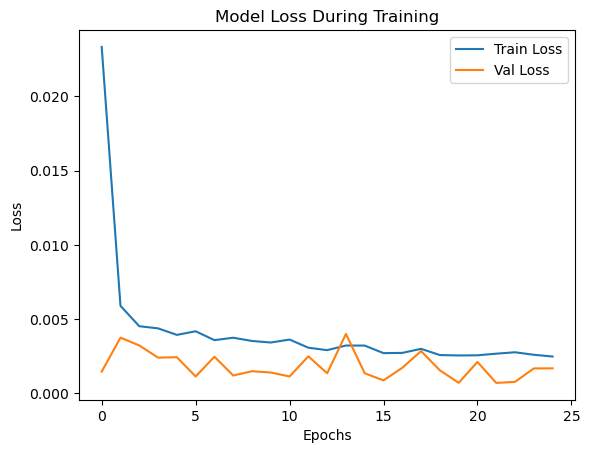

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
y_pred = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [14]:
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test.reshape(-1, 1))

# plotting the real and predicted price

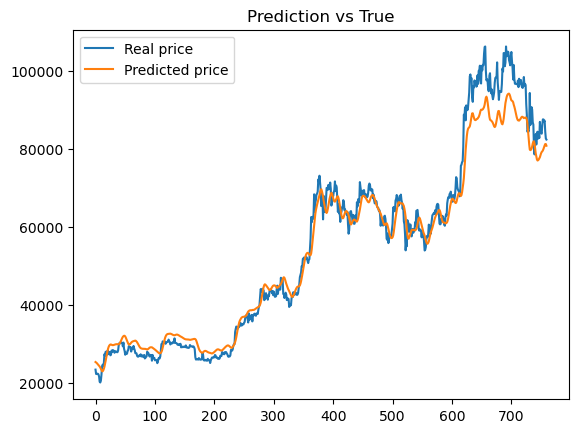

In [15]:
plt.plot(y_test_inversed, label='Real price')
plt.plot(y_pred_inversed, label='Predicted price')
plt.legend()
plt.title("Prediction vs True")
plt.show()

In [16]:
total_data = pd.concat([train, test])

In [17]:
# Create the predicted dataframe and align the indices properly
predicted_df = pd.DataFrame(y_pred_inversed, index=test.index[60:])  # Align indices with test[60:]

# Plotting the real and predicted price on the whole period

In [19]:
# Create a copy of the original data to add predictions
data_with_predictions = data.copy()

# Initialize the 'Predicted' column with NaN for all rows
data_with_predictions['Predicted'] = None  

# Fill in the predicted values starting from the 61st data point
data_with_predictions.loc[test.index[60:], 'Predicted'] = y_pred_inversed

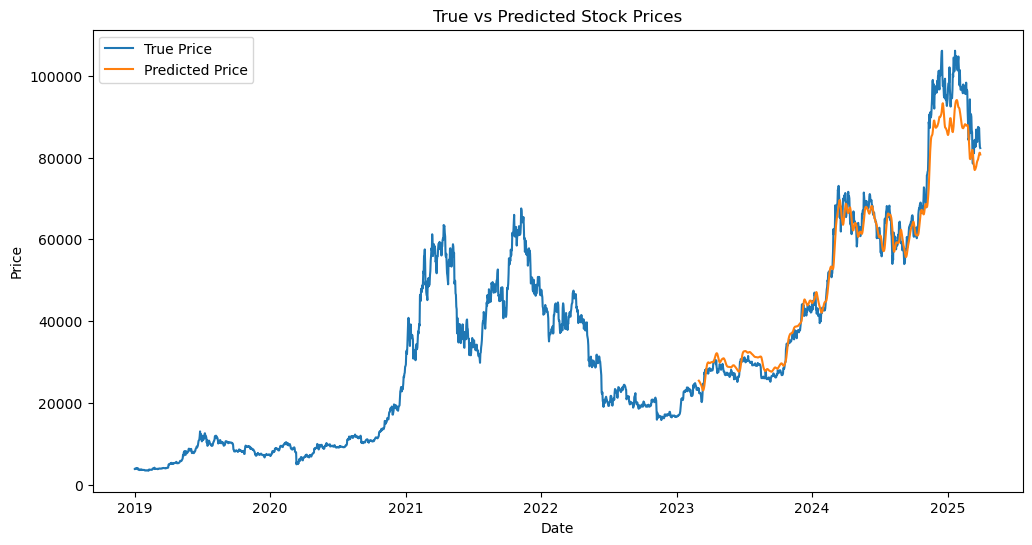

In [20]:
# Plot the true vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data_with_predictions['Close'], label='True Price')  # True prices
plt.plot(data_with_predictions['Predicted'], label='Predicted Price')  # Predicted prices
plt.legend()
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()